In [1]:
# path of the data directory
from voxelwise_tutorials.io import get_data_home
directory = get_data_home(dataset="vim-2")
print(directory)

# modify to use another subject
subject = "subject1"

/home/jlg/yuerou/voxelwise_tutorials_data/vim-2


In [2]:
import os
import h5py

file_name = os.path.join(directory, f'VoxelResponses_{subject}.mat')
with h5py.File(file_name, 'r') as f:
    print(f.keys())  # Show all variables
    for key in f.keys():
        print(f[key])

<KeysViewHDF5 ['ei', 'roi', 'rt', 'rv', 'rva']>
<HDF5 group "/ei" (4 members)>
<HDF5 group "/roi" (30 members)>
<HDF5 dataset "rt": shape (73728, 7200), type "<f4">
<HDF5 dataset "rv": shape (73728, 540), type "<f4">
<HDF5 dataset "rva": shape (73728, 10, 540), type "<f4">


In [3]:
import numpy as np

from voxelwise_tutorials.io import load_hdf5_array

file_name = os.path.join(directory, f'VoxelResponses_{subject}.mat')
Y_train = load_hdf5_array(file_name, key='rt')
Y_test_repeats = load_hdf5_array(file_name, key='rva')

# transpose to fit in scikit-learn's API
Y_train = Y_train.T
Y_test_repeats = np.transpose(Y_test_repeats, [1, 2, 0])

# Change to True to select only voxels from (e.g.) left V1 ("v1lh");
# Otherwise, all voxels will be modeled.
if False:
    roi = load_hdf5_array(file_name, key='/roi/v1lh').ravel()
    mask = (roi == 1)
    Y_train = Y_train[:, mask]
    Y_test_repeats = Y_test_repeats[:, :, mask]

# Z-score test runs, since the mean and scale of fMRI responses changes for
# each run. The train runs are already zscored.
Y_test_repeats -= np.mean(Y_test_repeats, axis=1, keepdims=True)
Y_test_repeats /= np.std(Y_test_repeats, axis=1, keepdims=True)

# Average test repeats, since we cannot model the non-repeatable part of
# fMRI responses.
Y_test = Y_test_repeats.mean(0)

# remove nans, mainly present on non-cortical voxels
Y_train = np.nan_to_num(Y_train)
Y_test = np.nan_to_num(Y_test)

In [4]:
file_name = os.path.join(directory, "features", "motion_energy.hdf")
X_train = load_hdf5_array(file_name, key='X_train')
X_test = load_hdf5_array(file_name, key='X_test')

# We use single precision float to speed up model fitting on GPU.
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [5]:
from sklearn.model_selection import check_cv
from voxelwise_tutorials.utils import generate_leave_one_run_out

n_samples_train = X_train.shape[0]

# indice of first sample of each run, each run having 600 samples
run_onsets = np.arange(0, n_samples_train, 600)

# define a cross-validation splitter, compatible with scikit-learn
cv = generate_leave_one_run_out(n_samples_train, run_onsets)
cv = check_cv(cv)  # copy the splitter into a reusable list

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Display the scikit-learn pipeline with an HTML diagram.
from sklearn import set_config
set_config(display='diagram')  # requires scikit-learn 0.23

In [7]:
from himalaya.kernel_ridge import KernelRidgeCV

In [8]:
from voxelwise_tutorials.delayer import Delayer

In [9]:
from himalaya.backend import set_backend
backend = set_backend("torch_cuda", on_error="warn")

/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to torch_cuda failed: PyTorch not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [10]:
alphas = np.logspace(1, 20, 20)

In [11]:
pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4, 5, 6, 7, 8]),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=100, n_alphas_batch=2,
                           n_targets_batch_refit=50),
        Y_in_cpu=True),
)
pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('delayer', Delayer(delays=[1, 2, 3, 4, 5, 6, 7, 8])),
                ('kernelridgecv',
                 KernelRidgeCV(Y_in_cpu=True,
                               alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                               cv=_CVIterableWrapper(cv=[(array([   0,    1...199])), (array([ 600,  601, ..., 7198, 7199]), array([  0,   1, ..., 598, 599])), (array([   0,    1, ..., 7198, 7199]), array([1200, 1201, ..., 1798, 1799])), (array([   0,    1, ..., 7198, 7199]), array([6000, 6001, ..., 659...1, ..., 5398, 5399])), (array([   0,    1, ..., 7198, 7199]), array([ 600,  601, ..., 1198, 1199]))]),
                               solver_params={'n_alphas_batch': 2,
                                              'n_targets_batch': 100,
                                              'n_targets_batch_refit': 50}))])

In [12]:
pipeline.fit(X_train, Y_train)

scores = pipeline.score(X_test, Y_test)
# Since we performed the KernelRidgeCV on GPU, scores are returned as
# torch.Tensor on GPU. Thus, we need to move them into numpy arrays on CPU, to
# be able to use them e.g. in a matplotlib figure.
scores = backend.to_numpy(scores)

/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/scoring.py:61: RuntimeWarning: divide by zero encountered in divide
  r2 = 1. - error / var
/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/scoring.py:61: RuntimeWarning: invalid value encountered in divide
  r2 = 1. - error / var


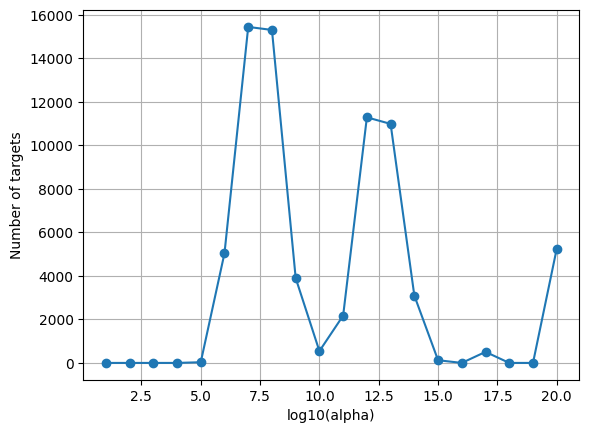

In [13]:
import matplotlib.pyplot as plt
from himalaya.viz import plot_alphas_diagnostic

plot_alphas_diagnostic(best_alphas=backend.to_numpy(pipeline[-1].best_alphas_),
                       alphas=alphas)
plt.show()

In [14]:
pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=100, n_alphas_batch=2,
                           n_targets_batch_refit=50),
        Y_in_cpu=True),
)
pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('kernelridgecv',
                 KernelRidgeCV(Y_in_cpu=True,
                               alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                               cv=_CVIterableWrapper(cv=[(array([   0,    1, ..., 7198, 7199]), array([3600, 3601, ..., 4198, 4199])), (array([ 600,  601, ..., 7198, 7199]), array([  0,   1, ..., 598, 599])), (array([   0,    1, ..., 7198, 7199]), array([1200, 1201, ..., 1798, 1799])), (array([   0,    1, ..., 7198, 7199]), array([6000, 6001, ..., 659...1, ..., 5398, 5399])), (array([   0,    1, ..., 7198, 7199]), array([ 600,  601, ..., 1198, 1199]))]),
                               solver_params={'n_alphas_batch': 2,
                                              'n_targets_batch': 100,
                                              'n_targets_batch_refit': 50}))])

In [15]:
pipeline.fit(X_train, Y_train)
scores_nodelay = pipeline.score(X_test, Y_test)
scores_nodelay = backend.to_numpy(scores_nodelay)

/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/kernel_ridge/_sklearn_api.py:490: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 7200 > 6555). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  warnings.warn(


/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/scoring.py:61: RuntimeWarning: divide by zero encountered in divide
  r2 = 1. - error / var
/home/jlg/yuerou/anaconda3/envs/book5/lib/python3.9/site-packages/himalaya/scoring.py:61: RuntimeWarning: invalid value encountered in divide
  r2 = 1. - error / var


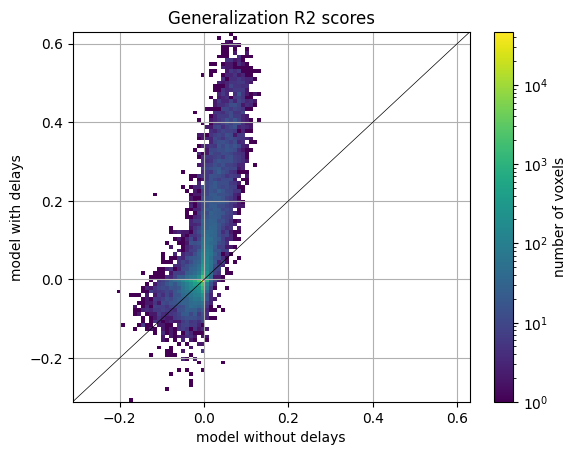

In [16]:
from voxelwise_tutorials.viz import plot_hist2d

ax = plot_hist2d(scores_nodelay, scores)
ax.set(title='Generalization R2 scores', xlabel='model without delays',
       ylabel='model with delays')
plt.show()